In [1]:
%pip install xarray cfgrib
%pip install cartopy
%pip install geopandas
%pip install regionmask

#%pip show cartopy
#%pip show cfgrib

%reset -f


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import pystac_client
import pystac
import itertools
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from dateutil.parser import parse
from datetime import datetime, timedelta
import warnings


import os
os.environ['PROJ_LIB'] = "/opt/conda/envs/geospatial/share/proj"
os.environ['decode_timedelta'] = "True"

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [3]:
#PySTAC
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
service

<Client id=INPE>

In [4]:
collection = service.get_collection('prec_merge_hourly-1')
collection

<CollectionClient id=prec_merge_hourly-1>

In [ ]:
def download_and_read_merge_stac(
    stac_service: str,
    start_date: str,
    end_date: str,
    output_dir: str = "merge_data"
):
    """
    Busca, baixa e lê dados MERGE em formato GRIB2 de um catálogo STAC,
    filtrando por um período de datas.

    Args:
        stac_catalog_url (str): URL do catálogo/item STAC.
        start_date (str): Data inicial (formato ISO ou legível, ex: '2024-01-01').
        end_date (str): Data final (formato ISO ou legível, ex: '2024-01-31').
        output_dir (str): Pasta onde salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset contendo os dados lidos.
    """
    # Converte datas para objetos datetime
    start_dt = parse(start_date)
    end_dt = parse(end_date)

    # Cria diretório de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    downloaded_files = []
    time = []

    if isinstance(service, pystac.Catalog) and stac_service.id == 'INPE':
        item_search = service.search(datetime=start_date+'/'+end_date,
                             collections=['prec_merge_hourly-1'])
        for asset in item_search.items():
            if asset.assets['merge_hourly'].href.endswith(".grib2"):
                file_url = asset.assets['merge_hourly'].href
                filename = Path(file_url).name
                file_path = output_path / filename
                grib_date = (asset.datetime + timedelta(hours=1)).strftime("%Y%m%d %H:00")
                #print (grib_date)

                print(f"Baixando: {file_url}")
                response = requests.get(file_url, stream=True)
                response.raise_for_status()

                with open(file_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024 * 1024):
                        if chunk:
                            f.write(chunk)

                        #print(f"Arquivo salvo: {file_path}")
                        downloaded_files.append(file_path)
                        time.append(grib_date)
    else:
        raise ValueError("STAC URL deve apontar para um Catálogo ou Item.")

    # Verifica se algum arquivo foi baixado
    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo .grib2 foi encontrado no período especificado.")

    # Lê os arquivos com xarray
    print("Lendo arquivos com xarray...")
          
    # Lê múltiplos arquivos com open_mfdataset, aplicando a função preprocess
    ds = xr.open_mfdataset(
        downloaded_files,
        engine='cfgrib',
        combine='nested',
        concat_dim='time',
        decode_timedelta=True)
    return ds

ds = download_and_read_merge_stac(service, '2024-08-09', '2024-08-10', '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp')
ds = ds.sortby('time')
ds

Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/11/MERGE_CPTEC_2024081100.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081023.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081022.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081021.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081020.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081019.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081018.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081017.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081016.grib2
Baixando: https://data.inpe.br/bdc/data/MERGE/GPM/HOURLY/2024/08/10/MERGE_CPTEC_2024081015.grib2
Baixando: https://data.inpe.br

Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081100.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081023.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081022.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081021.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081020.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081019.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081018.grib2.5b7b6.idx' older than GRIB file
Ignori

Lendo arquivos com xarray...


Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081011.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081010.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081009.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081008.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081007.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081006.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_2024081005.grib2.5b7b6.idx' older than GRIB file
Ignori

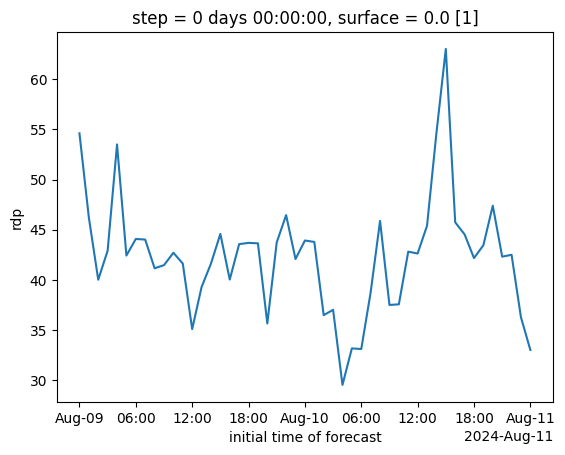

In [6]:
ds['rdp'].max(dim=['latitude', 'longitude']).plot()


In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def animate_precipitacao_merge(
    ds,
    var='rdp',
    title='Precipitação Total (MERGE)',
    cmap='YlGnBu',
    levels=np.linspace(0, 50, 51),
    extent=[-85, -34, -60, 15],  # Extent da América do Sul
    interval=300,                # milissegundos entre frames
    save_as=None                 # opcional: nome do arquivo para salvar (ex: 'animacao.mp4')
):
    """
    Cria uma animação da variável de precipitação do dataset MERGE para a América do Sul.

    Args:
        ds (xarray.Dataset): Dataset com os dados lidos.
        var (str): Nome da variável de precipitação. Padrão: 'prec'.
        title (str): Título do gráfico.
        cmap (str): Colormap usado.
        levels (array): Níveis do contorno para o plot.
        extent (list): [min_lon, max_lon, min_lat, max_lat] da região a ser plotada.
        interval (int): Milissegundos entre cada frame da animação.
        save_as (str): Nome do arquivo para salvar (opcional). Ex: 'animacao.mp4' ou 'animacao.gif'.
    """
    # Definir projeção
    proj = ccrs.PlateCarree()

    # Criar figura e eixo com projeção geográfica
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

    # Primeiro frame (para inicializar)
    pcm = ds[var][0].plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap=cmap,
        levels=levels,
        extend='max',
        add_colorbar=True,
        cbar_kwargs={'shrink': 0.7, 'label': 'Precipitação (mm/h)'}
    )

    # Configurações do mapa
    ax.set_title(title, fontsize=14)
    ax.set_extent(extent, crs=proj)

    # Adicionar limites continentais e países
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.5)

    # Grid e rótulos
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Função de atualização de cada frame
    def update(frame):
        pcm.set_array(ds[var][frame].values.ravel())
        time_str = ds['time'][frame].dt.strftime("%Y-%m-%d %H:%M").item()
        ax.set_title(f"{title} - {time_str}")
        return pcm,

    # Criar a animação
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=ds.dims['time'],
        interval=interval,
        blit=False
    )

    plt.tight_layout()

    # Salvar, se necessário
    if save_as:
        if save_as.endswith('.mp4'):
            writer = animation.FFMpegWriter(fps=2, metadata=dict(artist='FernandesAA'), bitrate=1800)
            ani.save(save_as, writer=writer)
        elif save_as.endswith('.gif'):
            ani.save(save_as, writer='pillow', fps=2)
        else:
            raise ValueError("Formato não suportado. Use .mp4 ou .gif")

    plt.close()  # Evita mostrar o plot estático
    return ani  # Retorna a animação para exibição no Jupyter

In [8]:
# Chamar a função de animação
ani = animate_precipitacao_merge(ds.sortby('time'), extent=[-52.9518,-44.1291,-25.7323,-19.2479], levels=np.linspace(0, 10, 11), var='rdp')

# Para exibir no notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

/tmp/ipykernel_1894/3629822133.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  frames=ds.dims['time'],
